In [1]:
import report_utils
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score, f1_score
import time
from tqdm import tqdm
import multiprocessing_notebook_helpers
import random 
import multiprocessing
import logging
from pathlib import Path
from IPython.display import clear_output

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, BatchNormalization 
from tensorflow.keras.layers import  Activation, Dropout, TimeDistributed
from tensorflow.keras.layers import LSTM, RepeatVector, Flatten, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import anomalyutils
import utils

import gc

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# def create_dfs(X,Y):
#     original_features = ["A_IGBT_I", "A_starIGBT_I", "B_IGBT_I", "B_starIGBT_I",
#                      "C_IGBT_I", "C_starIGBT_I", "A_Flux", "B_Flux", "C_Flux",
#                      "Mod_V", "Mod_I", "CB_I", "CB_V", "DV_DT"]
#     df_list = []
#     for i_x, i_y in zip(X, Y):
#         tmp_df = pd.DataFrame(i_x, 
#                             columns=original_features)
#         if i_y[1]== "Fault":
#             tmp_df["anomaly"] = 1
#         elif i_y[1]== "Run":
#             tmp_df["anomaly"] = 0
#         else:
#             raise ValueError("SOMETHING IS WRING!!!")
        
#         df_list.append(tmp_df)

#     df_all = pd.concat(df_list, axis=0, ignore_index=True)
#     df_Y = pd.DataFrame(Y, columns=["name", "status","reason"])
#     df_Y["anomaly"] = df_Y.apply(lambda x: 1 if x["status"] == "Fault" else 0, axis=1)
#     return df_all, df_Y

# path_to_new_data = "./data/Real_Electronic_Signal_Data_from_Particle_Accelerator_Power_Systems"
# system_1="CCL"
# system_2="DTL"
# system_3="RFQ"
# system_4="SCL"
# # X= np.load(f'{path_to_new_data}/{system}.npy')   #---> X array has shape: (pulses, times, features)
# # Y=np.load(f'{path_to_new_data}/{system}_labels.npy', allow_pickle=True)  #---> Y array has shape: (pulses, labels) --> labels are: index, state, type
# # time_steps=np.arange(X.shape[1]) * 400e-9    #create time axis based on the sampling rate 400 ns (for plotting purposes)

# # The 14 waveforms ( features ) reported in the dataset in order are:
# # original_features = ["A_IGBT_I", "A_starIGBT_I", "B_IGBT_I", "B_starIGBT_I",
# #                      "C_IGBT_I", "C_starIGBT_I", "A_Flux", "B_Flux", "C_Flux",
# #                      "Mod_V", "Mod_I", "CB_I", "CB_V", "DV_DT"]

# # CCL_X = np.load(f'{path_to_new_data}/{system_1}.npy')
# # CCL_Y = np.load(f'{path_to_new_data}/{system_1}_labels.npy', allow_pickle=True)
# # CCL_df, CCL_df_Y = create_dfs(CCL_X,CCL_Y)

# # DTL_X = np.load(f'{path_to_new_data}/{system_2}.npy')
# # DTL_Y = np.load(f'{path_to_new_data}/{system_2}_labels.npy', allow_pickle=True)
# # DTL_df, DTL_df_Y = create_dfs(DTL_X,DTL_Y)

# RFQ_X = np.load(f'{path_to_new_data}/{system_3}.npy')
# RFQ_Y = np.load(f'{path_to_new_data}/{system_3}_labels.npy', allow_pickle=True)
# RFQ_df, RFQ_df_Y = create_dfs(RFQ_X,RFQ_Y)

# # RFQ_df = pd.concat([RFQ_df[:4500*20].reset_index(drop=True), RFQ_df[-4500*5:].reset_index(drop=True)], axis=0).reset_index(drop=True)
# # RFQ_df_Y = pd.concat([RFQ_df_Y[:20].reset_index(drop=True), RFQ_df_Y[-5:].reset_index(drop=True)], axis=0).reset_index(drop=True)

# # SCL_X = np.load(f'{path_to_new_data}/{system_4}.npy')
# # SCL_Y = np.load(f'{path_to_new_data}/{system_4}_labels.npy', allow_pickle=True)
# # SCL_df, SCL_df_Y = create_dfs(SCL_X,SCL_Y)

In [3]:
# display(RFQ_df[:4500].head(100)[35:].head(20))
# display(RFQ_df[-4500:].head(100)[35:].head(20))

In [4]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# original_features = ["A_IGBT_I", "A_starIGBT_I", "B_IGBT_I", "B_starIGBT_I",
#                      "C_IGBT_I", "C_starIGBT_I", "A_Flux", "B_Flux", "C_Flux",
#                      "Mod_V", "Mod_I", "CB_I", "CB_V", "DV_DT"]

In [5]:
# for cl in original_features:
#     for i, df in enumerate([RFQ_df[:4500], RFQ_df[-4500:]]):
#         tmp_title = "aaaaaa"
#         if i<1:
#             tmp_title = "normal"
#         else:
#             tmp_title = "anomaly"
#         sns.lineplot(df[[cl]]).set_title(f"{cl}\n{tmp_title}_{i}")
#         plt.show()

In [6]:
def set_random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

The 14 waveforms ( features ) reported in the dataset in order are:
1. A + IGBT-I: The current passing through the IGBT switch of phase A + in Qa1 in Fig. 2 (unit:
A).
2. A + ∗IGBT-I: The current passing through the IGBT switch of phase A + ∗ in Qa3 in
Fig. 2 (unit: A).
3. B + IGBT-I: The current passing through the IGBT switch of phase B + in Qb1 in Fig. 2 (unit:
A).
4. B + ∗IGBT-I: The current passing through the IGBT switch of phase B + ∗ in Qb3 in
Fig. 2 (unit: A).
5. C + IGBT-I: The current passing through the IGBT switch of phase C + in Qc1 in Fig. 2 (unit:
A).
6. C + ∗IGBT-I: The current passing through the IGBT switch of phase C + ∗ in Qc3 in
Fig. 2 (unit: A).
6
M.I. Radaideh, C. Pappas and S. Cousineau / Data in Brief 43 (2022) 108473
7. A-Flux: Magnetic flux density for phase A in transformer XA in Fig. 2 (unit: -).
8. B-Flux: Magnetic flux density for phase B in transformer XB in Fig. 2 (unit: -).
9. C-Flux: Magnetic flux density for phase C in transformer XC in Fig. 2 (unit: -).
10. Mod-V: Modulator voltage (unit: V).
11. Mod-I: Modulator current (unit: A).
12. CB-I: Cap bank current (unit: -).
13. CB-V: Cap bank voltage (unit: V).
14. DV/DT: Time derivative change of the Mod-V voltage (unit: -).

In [7]:
set_random(1)
# set_random(7)

In [8]:
def create_dfs(X,Y):
    original_features = ["A_IGBT_I", "A_starIGBT_I", "B_IGBT_I", "B_starIGBT_I",
                     "C_IGBT_I", "C_starIGBT_I", "A_Flux", "B_Flux", "C_Flux",
                     "Mod_V", "Mod_I", "CB_I", "CB_V", "DV_DT"]
    df_list = []
    for i_x, i_y in zip(X, Y):
        tmp_df = pd.DataFrame(i_x, 
                            columns=original_features)
        if i_y[1]== "Fault":
            tmp_df["anomaly"] = 1
        elif i_y[1]== "Run":
            tmp_df["anomaly"] = 0
        else:
            raise ValueError("SOMETHING IS WRONG!!!")
        
        df_list.append(tmp_df)

    df_all = pd.concat(df_list, axis=0, ignore_index=True)
    df_Y = pd.DataFrame(Y, columns=["name", "status","reason"])
    df_Y["anomaly"] = df_Y.apply(lambda x: 1 if x["status"] == "Fault" else 0, axis=1)
    return df_all, df_Y

In [9]:
path_to_new_data = "./data/Real_Electronic_Signal_Data_from_Particle_Accelerator_Power_Systems"
system_1="CCL"
system_2="DTL"
system_3="RFQ"
system_4="SCL"
# X= np.load(f'{path_to_new_data}/{system}.npy')   #---> X array has shape: (pulses, times, features)
# Y=np.load(f'{path_to_new_data}/{system}_labels.npy', allow_pickle=True)  #---> Y array has shape: (pulses, labels) --> labels are: index, state, type
# time_steps=np.arange(X.shape[1]) * 400e-9    #create time axis based on the sampling rate 400 ns (for plotting purposes)

# The 14 waveforms ( features ) reported in the dataset in order are:
# original_features = ["A_IGBT_I", "A_starIGBT_I", "B_IGBT_I", "B_starIGBT_I",
#                      "C_IGBT_I", "C_starIGBT_I", "A_Flux", "B_Flux", "C_Flux",
#                      "Mod_V", "Mod_I", "CB_I", "CB_V", "DV_DT"]

# CCL_X = np.load(f'{path_to_new_data}/{system_1}.npy')
# CCL_Y = np.load(f'{path_to_new_data}/{system_1}_labels.npy', allow_pickle=True)
# CCL_df, CCL_df_Y = create_dfs(CCL_X,CCL_Y)

# DTL_X = np.load(f'{path_to_new_data}/{system_2}.npy')
# DTL_Y = np.load(f'{path_to_new_data}/{system_2}_labels.npy', allow_pickle=True)
# DTL_df, DTL_df_Y = create_dfs(DTL_X,DTL_Y)

RFQ_X = np.load(f'{path_to_new_data}/{system_3}.npy')
RFQ_Y = np.load(f'{path_to_new_data}/{system_3}_labels.npy', allow_pickle=True)
RFQ_df, RFQ_df_Y = create_dfs(RFQ_X,RFQ_Y)

# SCL_X = np.load(f'{path_to_new_data}/{system_4}.npy')
# SCL_Y = np.load(f'{path_to_new_data}/{system_4}_labels.npy', allow_pickle=True)
# SCL_df, SCL_df_Y = create_dfs(SCL_X,SCL_Y)

In [10]:
# display(CCL_df.info(memory_usage="deep"))
# display(DTL_df.info(memory_usage="deep"))
# display(RFQ_df.info(memory_usage="deep"))
# display(SCL_df.info(memory_usage="deep"))

In [11]:
# display(CCL_df.memory_usage(deep=True))
# display(DTL_df.memory_usage(deep=True))
# display(RFQ_df.memory_usage(deep=True))
# display(SCL_df.memory_usage(deep=True))

In [12]:
# MB
# display(CCL_df.memory_usage(deep=True).sum()/1024/1024)
# display(DTL_df.memory_usage(deep=True).sum()/1024/1024)
# display(RFQ_df.memory_usage(deep=True).sum()/1024/1024)
# display(SCL_df.memory_usage(deep=True).sum()/1024/1024)

In [13]:
def get_predictd_df_Y(df, check_col):
    data_Y_list = []
    for i in range(0,len(df), 4500):
        if df.iloc[i:i+4500,:][check_col].astype(bool).any():
            data_Y_list.append((1,))
        else:
            data_Y_list.append((0,))
    data_Y = pd.DataFrame(data_Y_list, columns=[check_col]).reset_index(drop=True)
    return data_Y

In [14]:
# CCL_df_Y
# DTL_df_Y
# RFQ_df_Y
# SCL_df_Y
list_of_df_Y = [RFQ_df_Y]

# CCL_df
# DTL_df
# RFQ_df
# SCL_df
list_of_df = [RFQ_df]

In [15]:
def reverse_permutation(list_of_subs):
    permutation = []
    for subset in list_of_subs:
        for i in subset:
            permutation.append(i)
    permutation_indexing = {}
    for i in permutation:
        permutation_indexing[permutation[i]] = i
    reverse_permutation_list = []
    for i in range(len(permutation_indexing)):
        reverse_permutation_list.append(permutation_indexing[i])

    return reverse_permutation_list

def get_partitioned_data(data, number_of_subsets):
    number_of_features = data.shape[1]
    if number_of_features//number_of_subsets < 2:
        raise ValueError(f"Cannot partition {number_of_features} features into {number_of_subsets} subsets. Number_of_subsets/Number_of_features should be greated than 2.")
    random_permutation_feature_list = np.random.choice(number_of_features, number_of_features, replace=False).tolist()
    K = number_of_subsets
    N = int(len(random_permutation_feature_list)//K)
    subs = []
    for i in range(K):
        a_set = []
        for j in range(i*N,i*N+N):
            a_set.append(random_permutation_feature_list[j])
        subs.append(a_set)
    for i in range(K*N,len(random_permutation_feature_list)):
        subs[i-(K*N-1)-1].append(random_permutation_feature_list[i])

    partitioned_data = []
    for partition in subs:
        partitioned_data.append(np.array([data[:,i] for i in partition]).T)

    return partitioned_data, subs

def get_random_data(partition, fraction):
    random_data = np.take(partition, sorted(np.random.choice(int(partition.shape[0]), size=round(fraction*partition.shape[0]), replace=False).tolist()), axis=0)
    return random_data

def get_rotation_matrix(data):
    pca = PCA()
    pca.fit(data)
    rotation_matrix = pca.components_
    return rotation_matrix

In [16]:
def autoencoder(data):
    input_dots = Input((data.shape[1],))

    x = Dense(5)(input_dots)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Dense(4)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    bottleneck = Dense(2, activation='linear')(x)

    x = Dense(4)(bottleneck)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    out = Dense(data.shape[1], activation='linear')(x)

    model = Model(input_dots, out)
    model.compile(optimizer=Adam(0.005), loss='mae', metrics=["mse"])
    
    early_stopping = EarlyStopping(patience=3, verbose=0)
    model.fit(data, data,
                validation_split=0.2,
                epochs=40,
                batch_size=32,
                verbose=1,
                shuffle=True,
                callbacks=[early_stopping]
            )
    return model

## Conv_AE
def conv_ae(data):
    model = keras.Sequential(
        [
            layers.Input(shape=(data.shape[1], data.shape[2])),
            layers.Conv1D(
                filters=64, kernel_size=4, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1D(
                filters=32, kernel_size=3, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1D(
                filters=16, kernel_size=2, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=2, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=3, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=64, kernel_size=4, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    # model.summary()

    history = model.fit(
        data,
        data,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        verbose=1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0)
        ],
    )
    return model#, history
    

## LSTM
def lstm(data_x, data_y, name=None):
    name_of_method = ""
    if name is None:
        name_of_method = "lstm.h5"
    else:
        name_of_method = f"lstm_{name}.h5"
    
    n_features = data_x.shape[2]
    
    # model defining
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(data_x.shape[1], n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_features))
    
    model.compile(optimizer='adam', loss='mae', metrics=["mse"])
    
    # callbacks defining
    early_stopping = EarlyStopping(patience=10, verbose=0)
    model_checkpoint = ModelCheckpoint(name_of_method, save_best_only=True, verbose=0, save_weights_only=True)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=0)
    
    # model fitting
    history = model.fit(data_x, data_y,
                        validation_split=0.2,
                        epochs=25,
                        batch_size=32,
                        verbose=1,
                        shuffle=False,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])
    return model

## LSTM_AE
def lstm_ae(data):
    # model defining
    # define encoder
    inputs = keras.Input(shape=(data.shape[1], data.shape[2]))
    encoded = layers.LSTM(100, activation='relu')(inputs)

    # define reconstruct decoder
    decoded = layers.RepeatVector(data.shape[1])(encoded)
    decoded = layers.LSTM(100, activation='relu', return_sequences=True)(decoded)
    decoded = layers.TimeDistributed(layers.Dense(data.shape[2]))(decoded)

    # tie it together
    model = keras.Model(inputs, decoded)
    encoder = keras.Model(inputs, encoded)

    model.compile(optimizer='adam', loss='mae', metrics=["mse"])
    
    # callbacks defining
    early_stopping = EarlyStopping(patience=5, verbose=1)
#     reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=0)
    
    # model fitting
    history = model.fit(data, data,
                        validation_split=0.1,
                        epochs=100,
                        batch_size=32,
                        verbose=1,
                        shuffle=False,
                        callbacks=[early_stopping]#, reduce_lr]
                        )
    return model

## LSMTM_VAE
def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    x = Input(shape=(timesteps, input_dim,))

    # LSTM encoding
    h = LSTM(intermediate_dim)(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                mean=0., stddev=epsilon_std)
        return z_mean + z_log_sigma * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # decoded LSTM layer
    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    # decoded layer
    x_decoded_mean = decoder_mean(h_decoded)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)

    vae.compile(optimizer='rmsprop', loss="mae")
    
    return vae, encoder, generator

def lstm_vae(data):
    input_dim = data.shape[-1] # 13
    timesteps = data.shape[1] # 3
    BATCH_SIZE = 1
    
    model, enc, gen = create_lstm_vae(input_dim, 
        timesteps=timesteps, 
        batch_size=BATCH_SIZE, 
        intermediate_dim=32,
        latent_dim=100,
        epsilon_std=1.)

    history = model.fit(
        data,
        data,
        epochs=20,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0)
        ],
    )
    return model

In [17]:
df_data = list_of_df[0][:4500*20].drop(['anomaly'], axis=1)

In [18]:
StSc = StandardScaler()
StSc.fit(df_data)
transformed_data = StSc.transform(df_data)
transformed_data = pd.DataFrame(transformed_data, columns=df_data.columns, index=df_data.index)

In [19]:
# display(RFQ_df[:4500].head(100)[35:].head(20))
# display(RFQ_df[-4500:].head(100)[35:].head(20))

# display(pd.DataFrame(StSc.transform(list_of_df[0][:4500].drop(['anomaly'], axis=1)), columns=list_of_df[0][:4500].drop(['anomaly'], axis=1).columns, index=list_of_df[0][:4500].index).head(100)[35:].head(20))
# display(pd.DataFrame(StSc.transform(list_of_df[0][-4500:].drop(['anomaly'], axis=1)), columns=list_of_df[0][-4500:].drop(['anomaly'], axis=1).columns, index=list_of_df[0][-4500:].index).head(100)[35:].head(20))

In [20]:
possible_values = [int(i) for i in range(int(np.floor(transformed_data.shape[1]/2)), transformed_data.shape[1], 1)]
number_of_features = np.random.choice(possible_values, 1, replace=False)[0]
subset = sorted(np.random.choice(transformed_data.shape[1], number_of_features, replace=False).tolist())
data = transformed_data.to_numpy()
data = data[:,subset]
transformed_data = pd.DataFrame(data, columns=[transformed_data.columns.tolist()[i] for i in subset], index=transformed_data.index)

In [21]:
# # search for seed
# for r_seed in range(0,20,1):
#     set_random(r_seed)
#     StSc = StandardScaler()
#     StSc.fit(df_data)
#     transformed_data = StSc.transform(df_data)
#     transformed_data = pd.DataFrame(transformed_data, columns=df_data.columns, index=df_data.index)
#     possible_values = [int(i) for i in range(int(np.floor(transformed_data.shape[1]/2)), transformed_data.shape[1], 1)]
#     number_of_features = np.random.choice(possible_values, 1, replace=False)[0]
#     subset = sorted(np.random.choice(transformed_data.shape[1], number_of_features, replace=False).tolist())
#     data = transformed_data.to_numpy()
#     data = data[:,subset]
#     transformed_data = pd.DataFrame(data, columns=[transformed_data.columns.tolist()[i] for i in subset], index=transformed_data.index)
#     print(f"seed={r_seed} subset={subset}")

In [22]:
print(len(subset))
print(subset)

13
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13]


In [23]:
varK=2
varfraction=0.75
data = transformed_data.to_numpy()
a_partition, permutation = get_partitioned_data(data, varK)
subsets = permutation
rotation_matricies = []
for partition in a_partition:
    random_data = get_random_data(partition, varfraction)
    rotation_matrix = get_rotation_matrix(random_data)
    rotation_matricies.append(rotation_matrix)

data = transformed_data.to_numpy()
transformed_partitions = []
for sub, rotation_matrix in zip(subsets, rotation_matricies):
    partition = np.array([data[:,i] for i in sub]).T
    transformed_partitions.append(np.dot(partition, rotation_matrix.T))

transformed_data_unordered = np.concatenate(transformed_partitions, axis=1)
reverse_perm = reverse_permutation(subsets)
data = transformed_data_unordered[:,reverse_perm]
transformed_data = pd.DataFrame(data, columns=transformed_data.columns.tolist(), index=transformed_data.index)

In [24]:
# display(transformed_data.info(memory_usage="deep"))

In [25]:
model_name = "CONV_AE"
task_name = "1"
model = None
UCL = None
X_conv_ae = None
predictions_conv_ae = None
residuals_conv_ae = None
WINDOW_SIZE = 64
if model_name.upper() == "AE":
    model = autoencoder(transformed_data)
    predictions_ae = anomalyutils.get_ae_predicts(model, transformed_data)
    residuals_autoencoder = anomalyutils.get_ae_residuals(transformed_data, predictions_ae)
    UCL = residuals_autoencoder.quantile(0.99)
elif model_name.upper() == "CONV_AE":
    X_conv_ae = utils.create_sequences(transformed_data, WINDOW_SIZE)
    model = conv_ae(X_conv_ae)
    predictions_conv_ae = anomalyutils.get_conv_ae_predicts(model, X_conv_ae)
    residuals_conv_ae = anomalyutils.get_conv_ae_residuals_mse(X_conv_ae, predictions_conv_ae)
    UCL = residuals_conv_ae.quantile(0.9)
elif model_name.upper() == "LSTM":
    transformed_data_np = transformed_data.to_numpy()
    X_lstm, y_lstm = utils.split_sequences(transformed_data_np, 10)
    model = lstm(X_lstm, y_lstm, f"{task_name}")
    model.load_weights(f"lstm_{task_name}.h5")
    predictions_lstm = anomalyutils.get_lstm_predicts(model, X_lstm)
    residuals_lstm = anomalyutils.get_lstm_residuals(y_lstm, predictions_lstm)
    UCL = residuals_lstm.quantile(0.99)
elif model_name.upper() == "LSTM_AE":
    X_lstm_ae = utils.create_sequences(transformed_data, 10)
    model = lstm_ae(X_lstm_ae)
    predictions_lstm_ae = anomalyutils.get_lstm_ae_predicts(model, X_lstm_ae)
    residuals_lstm_ae = anomalyutils.get_lstm_ae_residuals(X_lstm_ae, predictions_lstm_ae)
    UCL = residuals_lstm_ae.quantile(0.99)
elif model_name.upper() == "LSTM_VAE":
    X_lstm_vae = utils.create_sequences(transformed_data, 5)
    model = lstm_vae(X_lstm_vae)
    predictions_lstm_vae = anomalyutils.get_lstm_vae_predicts(model, X_lstm_vae)
    residuals_lstm_vae = anomalyutils.get_lstm_vae_residuals(X_lstm_vae, predictions_lstm_vae)
    UCL = residuals_lstm_vae.quantile(0.999)
else:
    raise NotImplemented(f"{model_name} Not implemnted yet!")

Epoch 1/100
2530/2530 [==============================] - 15s 5ms/step - loss: 0.8860 - val_loss: 0.9764
Epoch 2/100
2530/2530 [==============================] - 14s 5ms/step - loss: 0.8842 - val_loss: 0.9767
Epoch 3/100
2530/2530 [==============================] - 14s 6ms/step - loss: 0.8841 - val_loss: 0.9750
Epoch 4/100
2530/2530 [==============================] - 15s 6ms/step - loss: 0.8840 - val_loss: 0.9760
Epoch 5/100
2530/2530 [==============================] - 16s 6ms/step - loss: 0.8840 - val_loss: 0.9755
Epoch 6/100
2530/2530 [==============================] - 15s 6ms/step - loss: 0.8839 - val_loss: 0.9754
Epoch 7/100
2530/2530 [==============================] - 15s 6ms/step - loss: 0.8839 - val_loss: 0.9748
Epoch 8/100
2530/2530 [==============================] - 15s 6ms/step - loss: 0.8839 - val_loss: 0.9745
Epoch 9/100
2530/2530 [==============================] - 15s 6ms/step - loss: 0.8839 - val_loss: 0.9738
Epoch 10/100
2530/2530 [==============================] - 15s 6m

In [26]:
df_data = list_of_df[0].drop(['anomaly'], axis=1)

In [27]:
RFQ_df_good = 3
RFQ_df_bad = 5
RFQ_df = pd.concat([list_of_df[0].drop(['anomaly'], axis=1)[:(RFQ_df_good*4500)].reset_index(drop=True), list_of_df[0].drop(['anomaly'], axis=1)[-(RFQ_df_bad*4500):].reset_index(drop=True)], axis=0).reset_index(drop=True)
RFQ_df_Y = pd.concat([list_of_df_Y[0][:RFQ_df_good].reset_index(drop=True), list_of_df_Y[0][-RFQ_df_bad:].reset_index(drop=True)], axis=0).reset_index(drop=True)

asdasdasd = [RFQ_df]

df_data = asdasdasd[0]

In [28]:
transformed_data = StSc.transform(df_data)
transformed_data = pd.DataFrame(transformed_data, columns=df_data.columns, index=df_data.index)

In [29]:
# display(transformed_data[:4500].head(100)[35:].head(20))
# display(transformed_data[-4500:].head(100)[35:].head(20))

In [30]:
data = transformed_data.to_numpy()
data = data[:,subset]
transformed_data = pd.DataFrame(transformed_data, columns=[transformed_data.columns.tolist()[i] for i in subset], index=transformed_data.index)

In [31]:
# display(transformed_data[:4500].head(100)[35:].head(20))
# display(transformed_data[-4500:].head(100)[35:].head(20))

In [32]:
data = transformed_data.to_numpy()
transformed_partitions = []
for sub, rotation_matrix in zip(subsets, rotation_matricies):
    partition = np.array([data[:,i] for i in sub]).T
    transformed_partitions.append(np.dot(partition, rotation_matrix.T))

transformed_data_unordered = np.concatenate(transformed_partitions, axis=1)
reverse_perm = reverse_permutation(subsets)
data = transformed_data_unordered[:,reverse_perm]
transformed_data = pd.DataFrame(data, columns=transformed_data.columns.tolist(), index=transformed_data.index)

In [33]:
# display(transformed_data[:4500].head(100)[35:].head(20))
# display(transformed_data[-4500:].head(100)[35:].head(20))

In [34]:
transformed_data.shape

(36000, 13)

'AUC: 0.8 F1: 0.7499999999999999


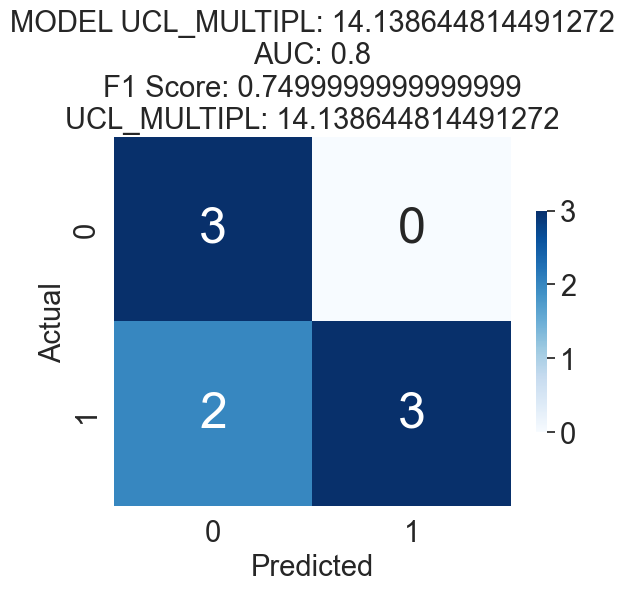

1

In [79]:
anomalous_data = pd.DataFrame(pd.Series(residuals_conv_ae.values, index=transformed_data[WINDOW_SIZE-1:].index).fillna(0)).rename(columns={0:f"cur_score"})
data_to_append = pd.DataFrame(pd.Series(pd.NA, index=transformed_data[:WINDOW_SIZE-1].index)).rename(columns={0:f"cur_score"})
all_data = pd.concat([data_to_append, anomalous_data], axis=0)

an_Y_list = []
for i in range(0,len(all_data), 4500):
    an_Y_list.append(all_data.iloc[i:i+4500,:].mean()[0])
an_data_Y = pd.DataFrame(an_Y_list, columns=["predicted_anomaly"]).reset_index(drop=True)

# print(all_data.count())
# print(all_data.sum())
# print(all_data.mean())
# print(all_data.sum()/all_data.count())
# display(all_data)
# display(an_data_Y)

# ax = sns.lineplot(an_data_Y)
# # plt.legend(False)
# ax.legend().set_visible(False)
# plt.show()


UCL_2 = an_data_Y.quantile(0.625)[0]

an_data_Y["predicted_anomaly"] = (an_data_Y["predicted_anomaly"]>UCL_2).astype(int)
final_df_tmp_tmp_a = pd.concat([an_data_Y,RFQ_df_Y], ignore_index=False, axis=1)
roc_number = roc_auc_score(final_df_tmp_tmp_a["anomaly"], final_df_tmp_tmp_a["predicted_anomaly"])
F1 = f1_score(final_df_tmp_tmp_a["anomaly"], final_df_tmp_tmp_a["predicted_anomaly"])
print(f"'AUC: {roc_number} F1: {F1}")
report_utils.plot_single_confusion_matrix(final_df_tmp_tmp_a, "predicted_anomaly", "anomaly", f"MODEL UCL_MULTIPL: {UCL_2}", f"UCL_MULTIPL: {UCL_2}", None)

1124/1124 [==============================] - 2s 2ms/step


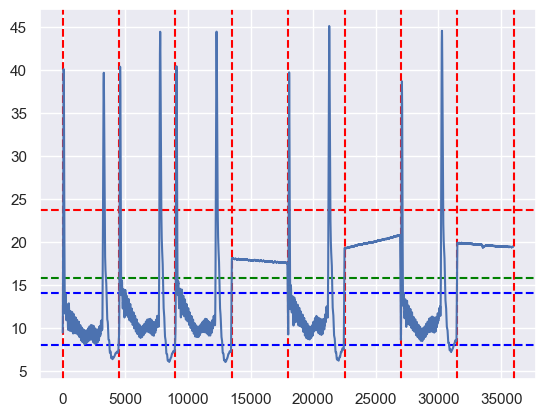

'AUC: 0.2 F1: 0.4000000000000001


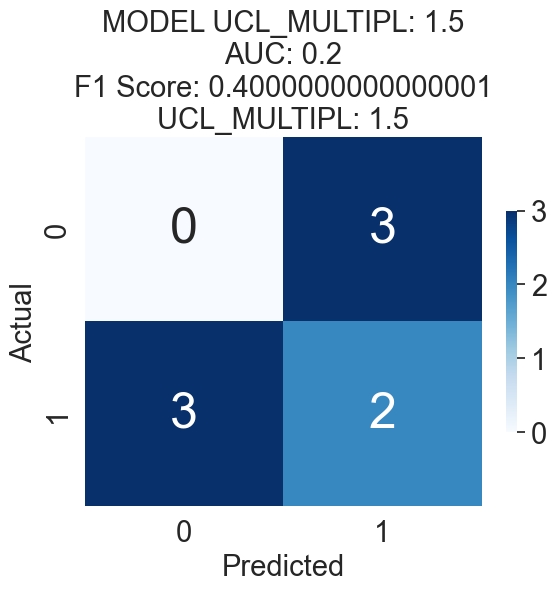

1

In [38]:
UCL_MULTIPL = 3/2
data_model = transformed_data.to_numpy()
X_conv_ae = utils.create_sequences(data_model, WINDOW_SIZE)
predictions_conv_ae = anomalyutils.get_conv_ae_predicts(model, X_conv_ae, None)
residuals_conv_ae = anomalyutils.get_conv_ae_residuals_mse(X_conv_ae, predictions_conv_ae)
df_final = utils.get_actual_scores_for_windows_v4(residuals_conv_ae, transformed_data, WINDOW_SIZE, UCL, "scores", "predicted_anomaly", UCL_MULTIPL)

plt.axvline(x=0, label=f"{str(0)}", color="red", linestyle="--")
for i in range(len(RFQ_df_Y)):
    plt.axvline(x=((i+1)*4500), label=f"{str((i+1)*4500)}", color="red", linestyle="--")
plt.axhline(y=(UCL), label=f"UCL", color="green", linestyle="--")
plt.axhline(y=(8), label=f"8", color="blue", linestyle="--")
plt.axhline(y=(14), label=f"14", color="blue", linestyle="--")
plt.axhline(y=(UCL*(UCL_MULTIPL)), label=f"UCL*{UCL_MULTIPL}", color="red", linestyle="--")
ax = sns.lineplot(residuals_conv_ae)
# plt.legend(False)
ax.legend().set_visible(False)
plt.show()

df_predicted = get_predictd_df_Y(df_final, "predicted_anomaly")
final_df_tmp_tmp_a = pd.concat([df_predicted,RFQ_df_Y], ignore_index=False, axis=1)
roc_number = roc_auc_score(final_df_tmp_tmp_a["anomaly"], final_df_tmp_tmp_a["predicted_anomaly"])
F1 = f1_score(final_df_tmp_tmp_a["anomaly"], final_df_tmp_tmp_a["predicted_anomaly"])
print(f"'AUC: {roc_number} F1: {F1}")
report_utils.plot_single_confusion_matrix(final_df_tmp_tmp_a, "predicted_anomaly", "anomaly", f"MODEL UCL_MULTIPL: {UCL_MULTIPL}", f"UCL_MULTIPL: {UCL_MULTIPL}", None)


1124/1124 [==============================] - 3s 3ms/step


,asd
predicted_anomaly,
0,8


'AUC: 0.5 F1: 0.0


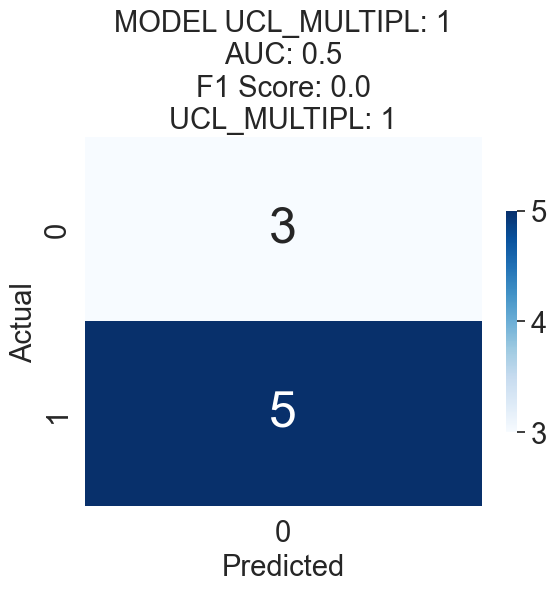

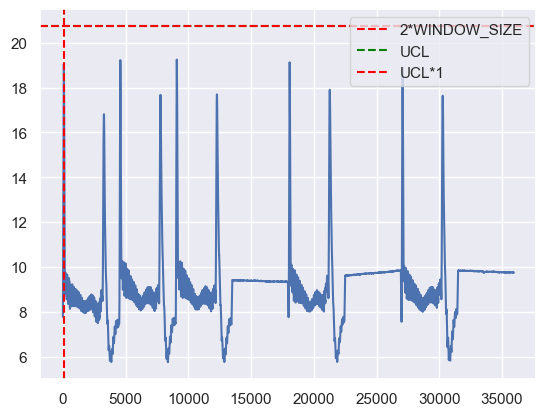

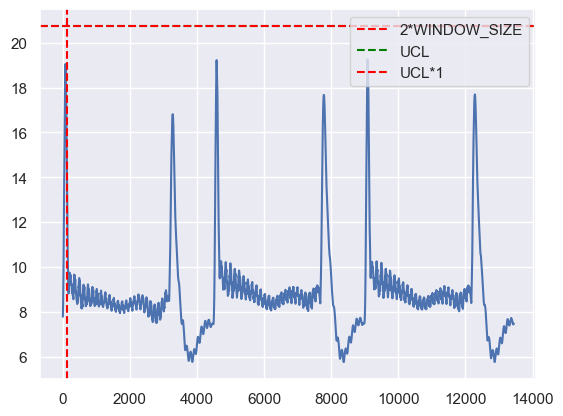

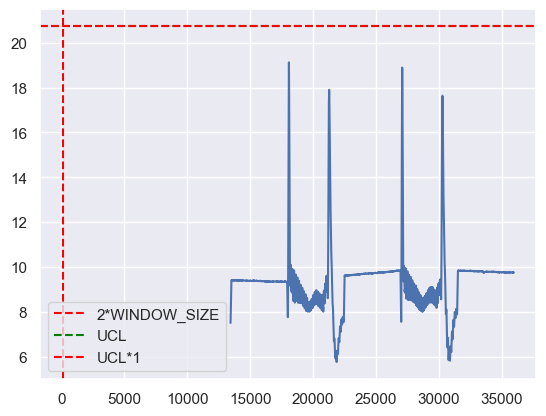

1124/1124 [==============================] - 3s 3ms/step


,asd
predicted_anomaly,
0,3
1,5


'AUC: 0.2 F1: 0.4000000000000001


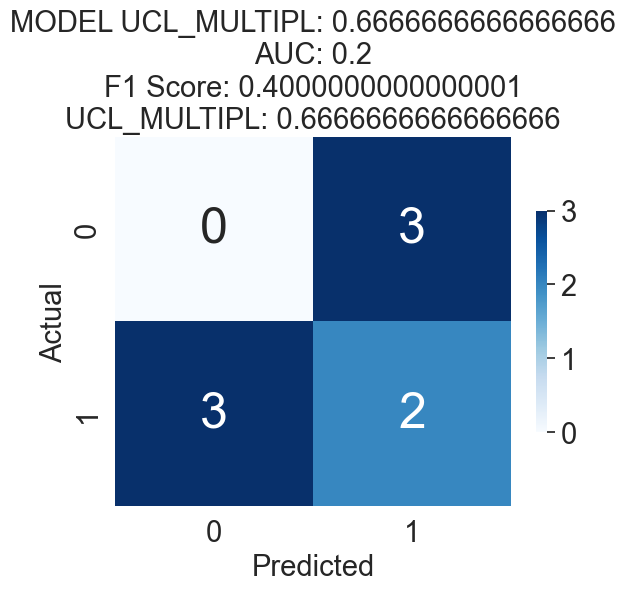

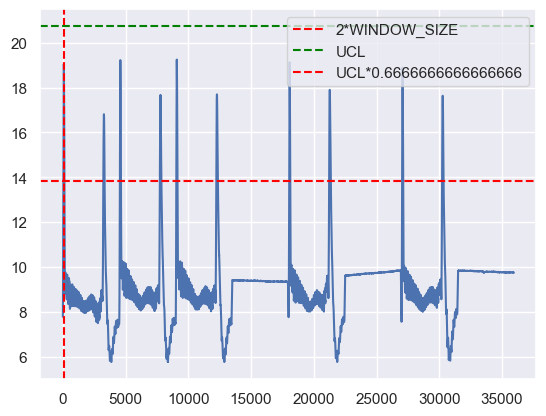

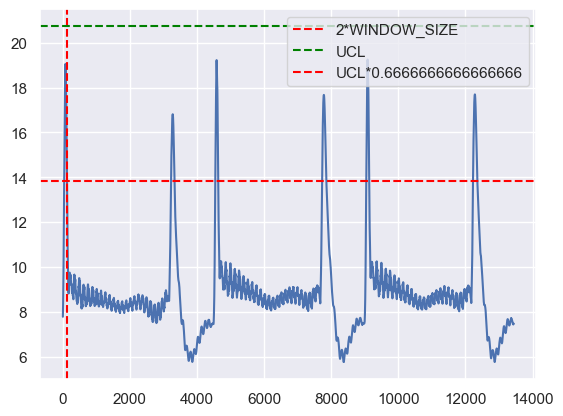

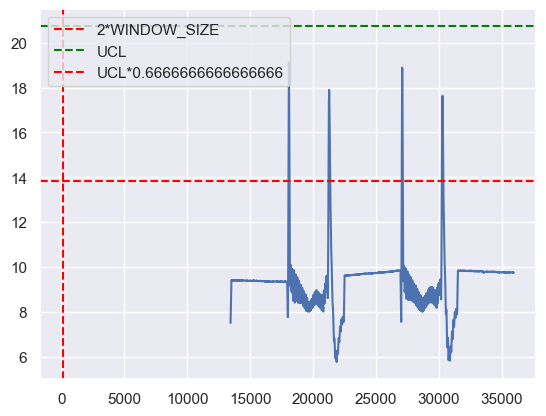

1124/1124 [==============================] - 3s 3ms/step


,asd
predicted_anomaly,
0,3
1,5


'AUC: 0.2 F1: 0.4000000000000001


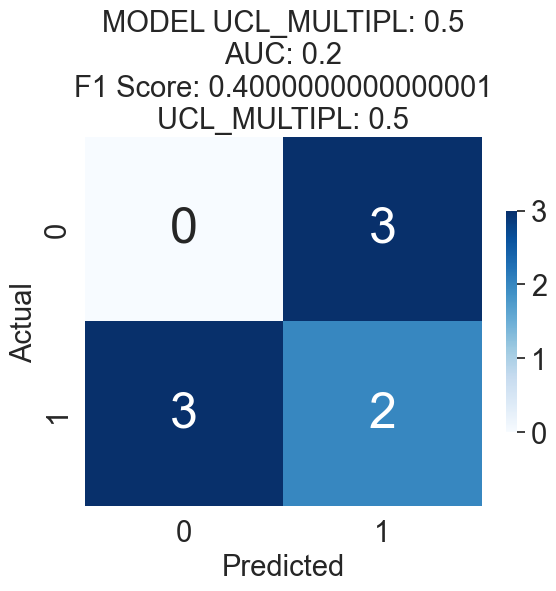

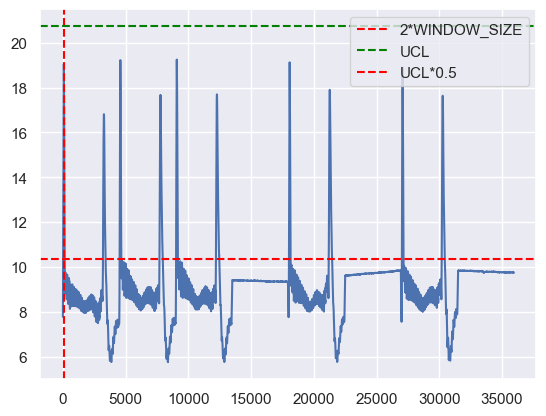

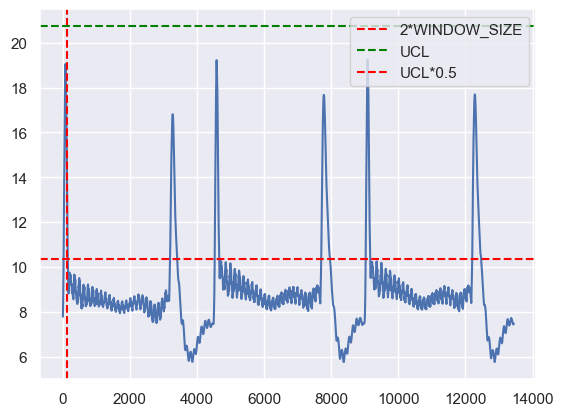

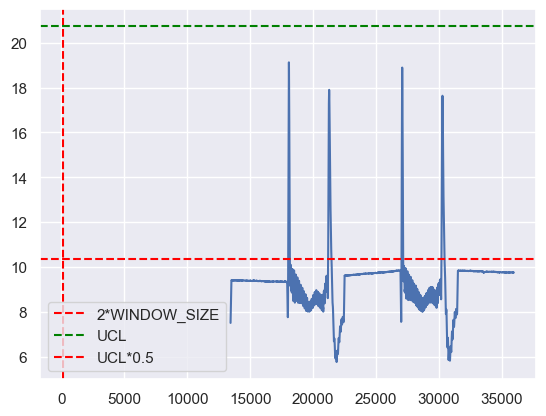

1124/1124 [==============================] - 3s 3ms/step


,asd
predicted_anomaly,
0,8


'AUC: 0.5 F1: 0.0


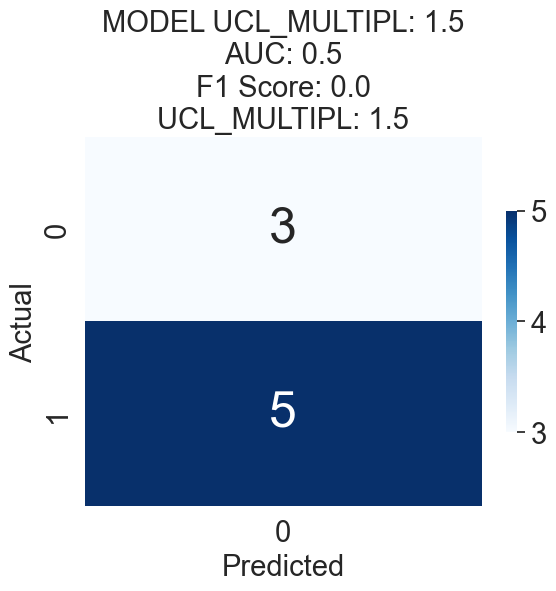

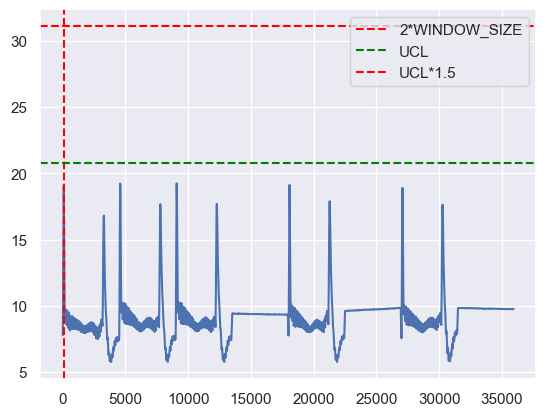

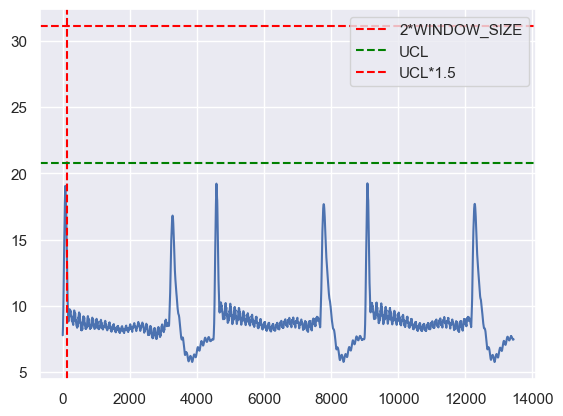

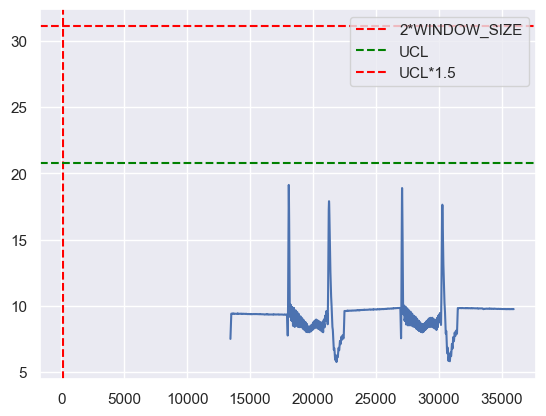

1124/1124 [==============================] - 3s 3ms/step


,asd
predicted_anomaly,
0,8


'AUC: 0.5 F1: 0.0


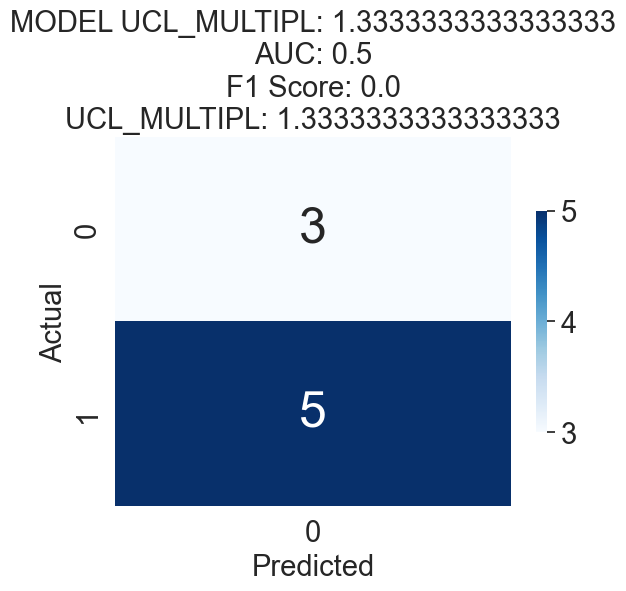

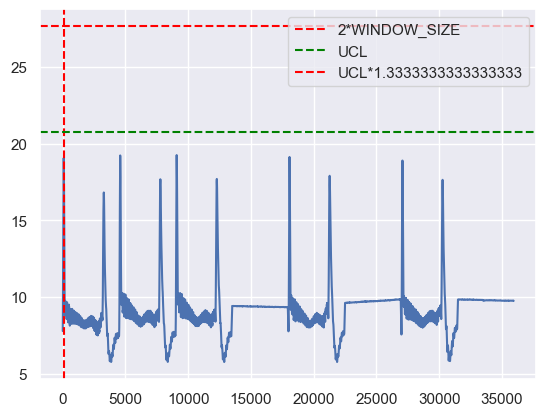

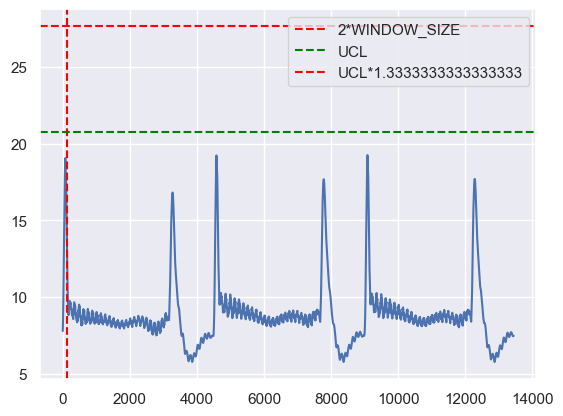

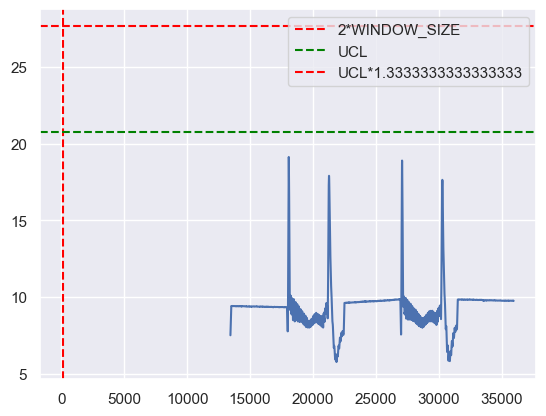

1124/1124 [==============================] - 3s 3ms/step


,asd
predicted_anomaly,
0,8


'AUC: 0.5 F1: 0.0


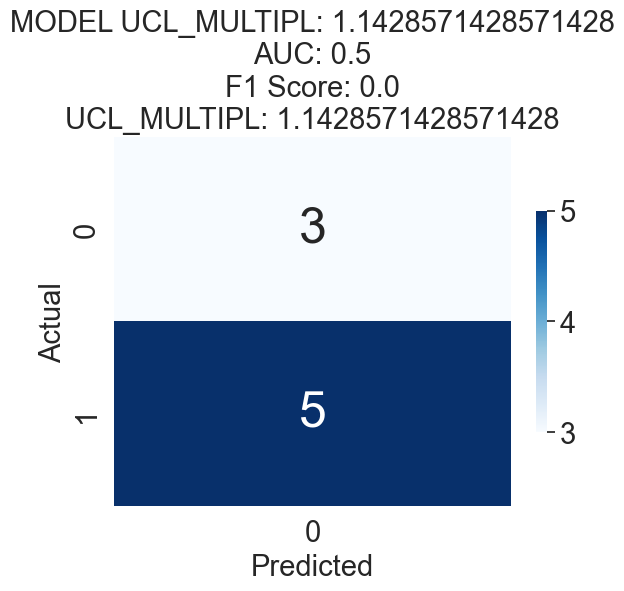

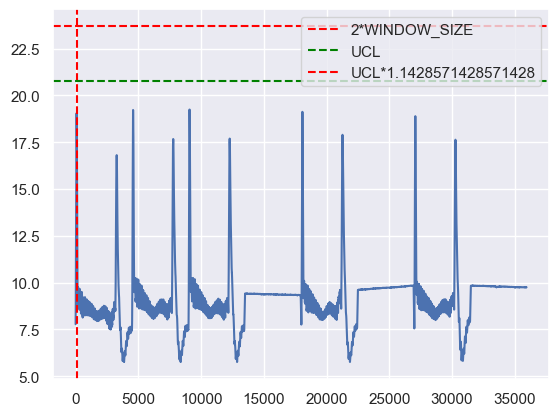

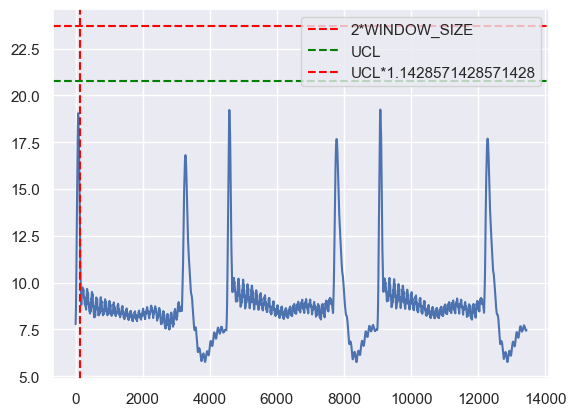

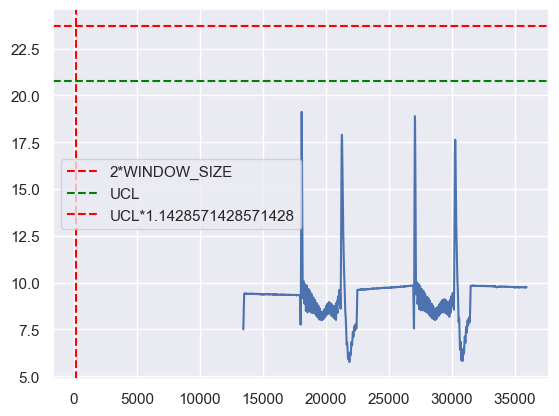

In [36]:
import seaborn as sns
from matplotlib import pyplot as plt

UCL_MULTIPL = 3/2
for UCL_MULTIPL in [1,2/3,2/4,3/2,4/3,8/7]:
    data_model = transformed_data.to_numpy()
    X_conv_ae = utils.create_sequences(data_model, WINDOW_SIZE)
    predictions_conv_ae = anomalyutils.get_conv_ae_predicts(model, X_conv_ae, None)
    residuals_conv_ae = anomalyutils.get_conv_ae_residuals(X_conv_ae, predictions_conv_ae)
    df_final = utils.get_actual_scores_for_windows_v4(residuals_conv_ae, transformed_data, WINDOW_SIZE, UCL, "scores", "predicted_anomaly", UCL_MULTIPL)

    df_predicted = get_predictd_df_Y(df_final, "predicted_anomaly")
    df_predicted["asd"] = "a"
    display(df_predicted.groupby("predicted_anomaly").count())

    final_df_tmp_tmp_a = pd.concat([df_predicted,RFQ_df_Y], ignore_index=False, axis=1)
    roc_number = roc_auc_score(final_df_tmp_tmp_a["anomaly"], final_df_tmp_tmp_a["predicted_anomaly"])
    F1 = f1_score(final_df_tmp_tmp_a["anomaly"], final_df_tmp_tmp_a["predicted_anomaly"])
    print(f"'AUC: {roc_number} F1: {F1}")
    report_utils.plot_single_confusion_matrix(final_df_tmp_tmp_a, "predicted_anomaly", "anomaly", f"MODEL UCL_MULTIPL: {UCL_MULTIPL}", f"UCL_MULTIPL: {UCL_MULTIPL}", None)

    sns.lineplot(residuals_conv_ae)
    plt.axvline(x=(2*WINDOW_SIZE), label=f"2*WINDOW_SIZE", color="red", linestyle="--")
    # plt.axvline(x=(4500), label=f"{str(4500)}", color="red", linestyle="--")
    plt.axhline(y=(UCL), label=f"UCL", color="green", linestyle="--")
    plt.axhline(y=(UCL*(UCL_MULTIPL)), label=f"UCL*{UCL_MULTIPL}", color="red", linestyle="--")
    plt.legend()
    plt.show()

    good_res = residuals_conv_ae[:(RFQ_df_good*4500)-WINDOW_SIZE]
    bad_res = residuals_conv_ae[(-RFQ_df_bad)*4500:]

    sns.lineplot(good_res)
    plt.axvline(x=(2*WINDOW_SIZE), label=f"2*WINDOW_SIZE", color="red", linestyle="--")
    # plt.axvline(x=(4500), label=f"{str(4500)}", color="red", linestyle="--")
    plt.axhline(y=(UCL), label=f"UCL", color="green", linestyle="--")
    plt.axhline(y=(UCL*(UCL_MULTIPL)), label=f"UCL*{UCL_MULTIPL}", color="red", linestyle="--")
    plt.legend()
    plt.show()

    sns.lineplot(bad_res)
    plt.axvline(x=(2*WINDOW_SIZE), label=f"2*WINDOW_SIZE", color="red", linestyle="--")
    # plt.axvline(x=(4500), label=f"{str(4500)}", color="red", linestyle="--")
    plt.axhline(y=(UCL), label=f"UCL", color="green", linestyle="--")
    plt.axhline(y=(UCL*(UCL_MULTIPL)), label=f"UCL*{UCL_MULTIPL}", color="red", linestyle="--")
    plt.legend()
    plt.show()

In [35]:
mult = "4/3"
mult_a = 2/3
plt.axvline(x=0, label=f"{str(0)}", color="red", linestyle="--")
for i in range(len(RFQ_df_Y)):
    plt.axvline(x=((i+1)*4500), label=f"{str((i+1)*4500)}", color="red", linestyle="--")
plt.axhline(y=(UCL), label=f"UCL", color="green", linestyle="--")
plt.axhline(y=(UCL*(mult_a)), label=f"UCL*{mult}", color="red", linestyle="--")
sns.lineplot(residuals_conv_ae)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [53]:
final_df = pd.concat([df_predicted,RFQ_df_Y], ignore_index=False, axis=1)
# roc_number = roc_auc_score(final_df["anomaly"], final_df["predicted_anomaly"])
# F1 = f1_score(final_df["anomaly"], final_df["predicted_anomaly"])
# print(f"'AUC: {roc_number} F1: {F1}")
# report_utils.plot_single_confusion_matrix(final_df, "predicted_anomaly", "anomaly", "ensemble_fbr_nr_conv_ae", "some_extra_info", None)
final_df

,predicted_anomaly,asd,name,status,reason,anomaly
0,1,a,./RFQ/RFQ_400ns_12_Day_Run_5.28.2022-5.08.29PM...,Run,Normal,0
1,0,a,./RFQ/RFQ_400ns_Fault_9.28.2021-6.55.03PM.csv,Fault,TPS Fault,1
2,1,a,./RFQ/RFQ_400ns_Fault_9.29.2020-3.04.52PM.csv,Fault,A- Driver Fault,1
3,1,a,./RFQ/RFQ_400ns_Fault_9.3.2021-4.17.48PM.csv,Fault,DV/DT High Fault,1
4,1,a,./RFQ/RFQ_400ns_Fault_9.30.2021-2.47.02PM.csv,Fault,SCR AC Input Fault,1
5,1,a,./RFQ/RFQ_400ns_Fault_9.8.2020-8.01.12AM.csv,Fault,TPS Fault,1


In [42]:
# display(data_model[:4500,:][:100,:][35:,:][:20,:])
# display(data_model[-4500:,:][:100,:][35:,:][:20,:])
# display(pd.DataFrame(X_conv_ae[:4500,30:,0]))
# display(pd.DataFrame(X_conv_ae[-4500:,30:,0]))
# display(pd.DataFrame(predictions_conv_ae[:4500,30:,0]))
# display(pd.DataFrame(predictions_conv_ae[-4500:,30:,0]))
tmp_anastasis = pd.DataFrame(residuals_conv_ae[:4500],columns=["residuals"])
display(tmp_anastasis.quantile(0.999)*(3/2))
display(pd.DataFrame(residuals_conv_ae[:4500]).iloc[70:])
display(pd.DataFrame(residuals_conv_ae[-4500:]).iloc[70:])
display(pd.DataFrame(residuals_conv_ae).max())

residuals    20.5396
Name: 0.999, dtype: float64

,0
70,9.303824
71,9.299596
72,9.295961
73,9.293221
74,9.290514
...,...
4495,13.694396
4496,13.697004
4497,13.699020
4498,13.701328


,0
2563,9.130096
2564,9.133370
2565,9.136173
2566,9.138907
2567,9.140995
...,...
6988,13.594897
6989,13.594928
6990,13.594803
6991,13.594833


0    13.70648
dtype: float32

In [27]:
# display(transformed_data.info(memory_usage="deep"))

In [30]:
chunk_size = 5000
df_final = None
if model_name.upper() == "AE":
    data = transformed_data.to_numpy()
    predictions_ae = anomalyutils.get_ae_predicts(model, data)
    residuals_autoencoder = anomalyutils.get_ae_residuals(data, predictions_ae)
    df_final = pd.DataFrame(pd.Series(residuals_autoencoder.values, index=df_data.index).fillna(0)).rename(columns={0:f"scores"})
    df_final["predicted_anomaly"] = (df_final["scores"] > (3/2)*UCL).astype(int)
    
elif model_name.upper() == "CONV_AE":
    data = transformed_data.to_numpy()
    X_conv_ae = utils.create_sequences(data, 60)
    print(f"X_conv_ae MB: {str(X_conv_ae.nbytes/1024/1024)}")
    del data
    gc.collect()
    predictions_conv_ae = anomalyutils.get_conv_ae_predicts(model, X_conv_ae, chunk_size)
    print(f"predictions_conv_ae MB: {str(predictions_conv_ae.nbytes/1024/1024)}")
    residuals_conv_ae = anomalyutils.get_conv_ae_residuals(X_conv_ae, predictions_conv_ae)
    print(f"residuals_conv_ae MB: {str(residuals_conv_ae.nbytes/1024/1024)}")
    del predictions_conv_ae
    gc.collect()
    df_final = utils.get_actual_scores_for_windows_v4(residuals_conv_ae, transformed_data, 60, UCL, "scores", "predicted_anomaly")
    
elif model_name.upper() == "LSTM":
    X_all_rotated = transformed_data.to_numpy()
    X_lstm, y_lstm = utils.split_sequences(X_all_rotated, 10)
    predictions_lstm = anomalyutils.get_lstm_predicts(model, X_lstm)
    residuals_lstm = anomalyutils.get_lstm_residuals(y_lstm, predictions_lstm)
    prediction_labels_lstm = pd.DataFrame(pd.Series(residuals_lstm.values, index=transformed_data[10:].index).fillna(0)).rename(columns={0:f"scores"})
    df_to_append = pd.DataFrame(pd.Series(0, index=transformed_data[:10].index).fillna(0)).rename(columns={0:f"scores"})
    df_final = pd.concat([df_to_append, prediction_labels_lstm], ignore_index=False)
    df_final["predicted_anomaly"] = (df_final["scores"] > (3/2) * UCL).astype(int)

elif model_name.upper() == "LSTM_AE":
    X_all_rotated = transformed_data.to_numpy()
    X_lstm_ae = utils.create_sequences(X_all_rotated, 10)
    predictions_lstm_ae = anomalyutils.get_lstm_ae_predicts(model, X_lstm_ae)
    residuals_lstm_ae = anomalyutils.get_lstm_ae_residuals(X_lstm_ae, predictions_lstm_ae)
    df_final = utils.get_actual_scores_for_windows_v4(residuals_lstm_ae, transformed_data, 10, UCL, "scores", "predicted_anomaly")
    
    
elif model_name.upper() == "LSTM_VAE":
    X_all_rotated = transformed_data.to_numpy()
    X_lstm_vae = utils.create_sequences(X_all_rotated, 5)
    predictions_lstm_vae = anomalyutils.get_lstm_vae_predicts(model, X_lstm_vae)
    residuals_lstm_vae = anomalyutils.get_lstm_vae_residuals(X_lstm_vae, predictions_lstm_vae)
    df_final = utils.get_actual_scores_for_windows_v4(residuals_lstm_vae, transformed_data, 5, UCL, "scores", "predicted_anomaly")
    
else:
    raise NotImplemented(f"{model_name} Not implemnted yet!")

122625/122625 [==============================] - 806s 7ms/step


In [31]:
# display(df_final.info(memory_usage="deep"))

In [32]:
df_predicted = get_predictd_df_Y(df_final, "predicted_anomaly")
df_predicted["asd"] = "a"
df_predicted.groupby("predicted_anomaly").count()

,asd
predicted_anomaly,
0,9
1,863


In [33]:
print(3/2*UCL)
print(UCL)

2.3069543838500968
1.5379695892333978


In [34]:
df_original = list_of_df_Y[0]
df_original = df_original[["anomaly"]]
df_original["asd"] = "a"
df_original.groupby("anomaly").count()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

,asd
anomaly,
0,690
1,182


In [35]:
df_original = list_of_df_Y[0]
df_original = df_original[["anomaly"]]

In [36]:
# window-60 ucl-975 (create_sequences for window-252 out of memory. cannot allocate for 47.5 GB)
final_df = pd.concat([df_predicted,df_original], ignore_index=False, axis=1)
roc_number = roc_auc_score(final_df["anomaly"], final_df["predicted_anomaly"])
F1 = f1_score(final_df["anomaly"], final_df["predicted_anomaly"])
print(f"'AUC: {roc_number} F1: {F1}")

'AUC: 0.4787466157031375 F1: 0.33301435406698565


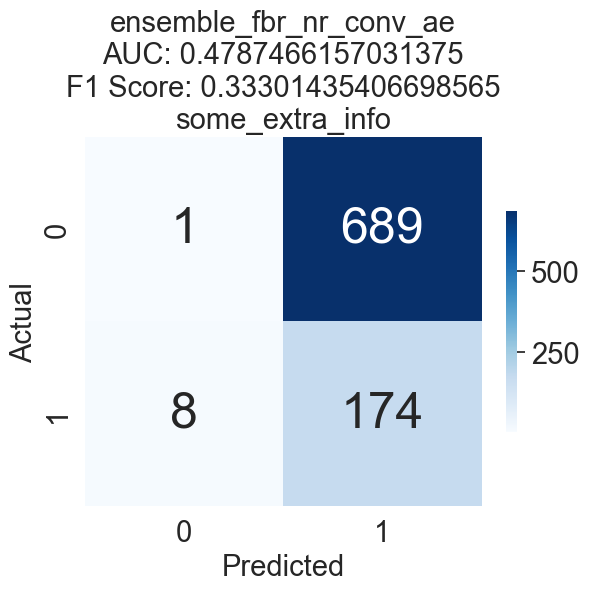

1

In [37]:
report_utils.plot_single_confusion_matrix(final_df, "predicted_anomaly", "anomaly", "ensemble_fbr_nr_conv_ae", "some_extra_info", "./asdasd.png")

In [38]:
#  0 690
# 11 171

In [39]:
# 'AUC: 0.5783723522853959 F1: 0.3695652173913043
# 347  343 
#  63  119